# Tensorflow Similarity Hello World

[FIXME intro blurb]

References
- Original paper:
FaceNet: A Unified Embedding for Face Recognition and Clustering
https://arxiv.org/abs/1503.03832 

- Mining strategies:
https://openaccess.thecvf.com/content_WACV_2020/papers/Xuan_Improved_Embeddings_with_Easy_Positive_Triplet_Mining_WACV_2020_paper.pdf 


In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
# from tqdm.auto import tqdm
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [3]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.visualization import viz_neigbors_imgs

In [4]:
tf_cap_memory()
print(tf.__version__)

2.3.1


# Preparing data
To demonstrate the ability of single-shot learning, we are going to train a model on even digit only but create
an index that contains a few examples of both even and odd digits to show how the model is able to do matching on 
unseen classes with few examples.


Note: Tensorflow similarity expect y_train to be the examples class as integer so there is no need for processing

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')

# keep only even digits for training
idxs = []
for idx in range(len(y_train)):
    if not y_train[idx] % 2:
        idxs.append(idx)
x_train_even = tf.gather(x_train, idxs)
y_train_even = tf.gather(y_train, idxs)
print(x_train.shape, y_train.shape)
print('x_train_even', x_train_even.shape, x_train_even.dtype)
print('y_train_even', y_train_even.shape, y_train_even.dtype)

(60000, 28, 28) (60000,)
x_train_even (29492, 28, 28) <dtype: 'float32'>
y_train_even (29492,) <dtype: 'uint8'>


In [6]:
print(y_train_even[:100])

tf.Tensor(
[0 4 2 4 6 2 8 6 4 0 2 4 2 8 6 0 6 0 6 8 8 0 4 8 0 4 4 4 6 0 4 6 0 0 6 0 2
 0 2 6 8 0 4 6 4 6 8 0 8 6 0 2 0 4 2 0 0 2 0 2 8 6 4 6 4 8 4 4 2 8 8 6 4 6
 6 0 2 8 2 4 4 6 4 0 2 2 2 6 2 8 2 2 0 4 8 2 8 6 0 0], shape=(100,), dtype=uint8)


In [7]:
# FIXME sampler here and select only half of the class

# model creation

In [8]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28,28,1))(inputs)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = MetricEmbedding(10)(x)
    # outputs2 = MetricEmbedding(10)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)          

# Loss definition

Overall Similarity losses (aka metric losses) are similar to other losses except they expect different inputs.

For triplet loss, one of the most popular one, you need to decide what type of triplet mining you want. Usually `hard` mining for positive example and `semi-hard` mining work well and are the default. They are passed explicitly here for reference.

The `distance` parameters specify which distance metric to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.


In [9]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard' #@param ["easy", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

# Compilation

Tensorflow similarity use an extended `compile()` method that allows you to specify distance_metrics (metrics that are computed over the distance between the embedding). 

By default the `compile()` method try to infers what type of distance you are using by looking at the fist loss specified. If you use multiples losses and the distance loss is not the first, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [10]:
model = get_model()
model.compile(optimizer='adam', loss=triplet_loss)

# Training

Similarity are trained like normal model. Don't expect the validation loss to decrease too much because we only use half of the class on the train data but all class in the validation.

In [11]:
EPOCHS = 5 #@param{Integer}
BATCH_SIZE = 16 #@param{Integer}
history = model.fit(x_train_even, y_train_even, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
1844/1844 [==============================] - 4s 2ms/step - loss: 0.1436 - val_loss: 0.7076
Epoch 2/5
1844/1844 [==============================] - 4s 2ms/step - loss: 0.0529 - val_loss: 0.7138
Epoch 3/5
1844/1844 [==============================] - 4s 2ms/step - loss: 0.0325 - val_loss: 0.7075
Epoch 4/5
1844/1844 [==============================] - 4s 2ms/step - loss: 0.0269 - val_loss: 0.6980
Epoch 5/5
1844/1844 [==============================] - 4s 2ms/step - loss: 0.0203 - val_loss: 0.7089


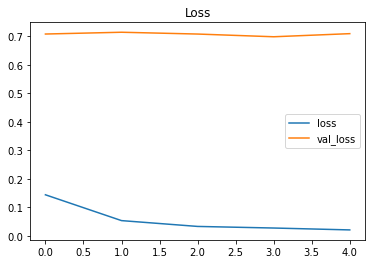

In [12]:
# let's visualizing loss overtime
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

# Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to create an index of known example from the 10 digits class. We do this by taking 100 examples from the train dataset which is about 3 examples for each digit and use the `index()` funtion of the model to build the index.

In [13]:
num_embeddings = 300
model.index(x_train[:num_embeddings], y_train[:num_embeddings])

# Querying

To "classify" our testing data, we need for each testing example to look for its nearest neighbors in our index. We are going to query a single example from our test dataset using the `single_lookup()` function.

Expected label: 6
  label    distances
-------  -----------
      6  0.000819206
      6  0.00111032
      6  0.00117433
      6  0.0012418
      6  0.00143486
      6  0.0015071 



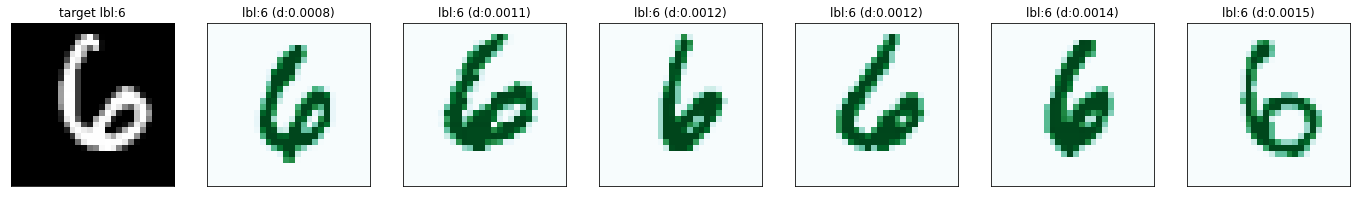

In [14]:
# query the closest points in our index for ALL 10000 test examples
num_neighboors = 6
test_id = 88  # 78 is a 9 a class we never trained on

# query closest matches
neighboors = model.single_lookup(x_test[test_id], k=num_neighboors)

# display results in tabular format
rows = [[n['label'], n['distance']] for n in neighboors]
print('Expected label: %d' % y_test[test_id])
print(tabulate(rows, headers=['label', 'distances']), '\n')

# view results close by
viz_neigbors_imgs(x_test[test_id], y_test[test_id], neighboors)

# Indexer stats

You can display the indexer performance summary using the `index_summary()` function.

In [15]:
model.index_summary()

[Index statistics]
----------------  ---
query_time          0
query               0
num_lookups         1
num_items         300
stat_buffer_size  100
----------------  ---

[Query performance]
------  -
min     0
max     0
avg     0
median  0
stddev  0
------  -


# matching

In [16]:
num_calibration_samples = 200
calibration = model.calibrate(x_train
[:num_calibration_samples], y_train[:num_calibration_samples], k=10, verbose=1)

num positive matches 1416/2000


label           distance
-----------  -----------
possible     0.0288222
likely       0.00458199
very_likely  0.000248671
match        0.0359477


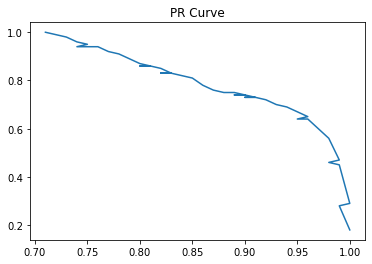

In [17]:
plt.plot(calibration['thresholds']['precision'], calibration['thresholds']['recall'])
plt.title("PR Curve")
plt.show()

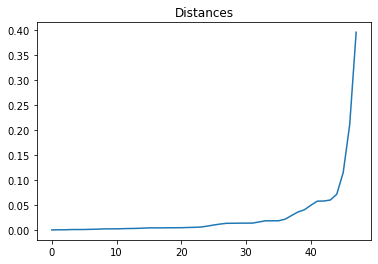

In [18]:
plt.plot(calibration['thresholds']['distance'])
plt.title("Distances")
plt.show()

In [19]:
rows = []
thresholds = calibration['thresholds']
for idx in range(len(thresholds['distance'])):
    rows.append([thresholds['distance'][idx], thresholds['f1'][idx], thresholds['precision'][idx], thresholds['recall'][idx]])

print(tabulate(rows, headers=['distance', 'f1', 'precision', 'recall']))

   distance        f1    precision    recall
-----------  --------  -----------  --------
0.000248671  0.309069         1         0.18
0.000498652  0.438326         0.99      0.28
0.00051856   0.451965         1         0.29
0.000980318  0.619186         0.99      0.45
0.00103468   0.630163         0.98      0.46
0.0010711    0.635407         0.99      0.47
0.00142562   0.709213         0.98      0.56
0.00171316   0.737118         0.97      0.6
0.00231791   0.769101         0.96      0.64
0.00234365   0.769296         0.95      0.64
0.00237638   0.771368         0.96      0.65
0.00276017   0.783292         0.95      0.67
0.0030542    0.793328         0.94      0.69
0.00326419   0.795491         0.93      0.7
0.00376821   0.804434         0.92      0.72
0.0042907    0.80984          0.91      0.73
0.0042969    0.809988         0.9       0.73
0.00431204   0.810452         0.91      0.73
0.00458175   0.810518         0.9       0.74
0.00458199   0.810205         0.89      0.74
0.00464582  